In [14]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import poppy

In [15]:
# fn = 'M3.h5'
fn = 'OAP1.h5'
f = h5py.File(fn, 'r')
f['measurement0'].keys()

<KeysViewHDF5 ['Detectormask', 'analyzed', 'fiducials', 'genraw', 'maskshapes', 'padding_offsets', 'reserve_interferogram', 'roi_rect', 'unitcircle']>

<ipython-input-80-5a1b87ebb0ce>:2: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dmask = f['measurement0'].get('Detectormask').value
<ipython-input-80-5a1b87ebb0ce>:6: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  genraw_data = f['measurement0']['genraw'].get('data').value
<ipython-input-80-5a1b87ebb0ce>:16: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  data = h5py.File(h5pth,'r')['measurement0']['genraw'].get('data').value


(1218, 1218)
(1218, 1218)
(1218, 1218)
(1218, 1218)
(1218, 1218)
(1218, 1218)
(1218, 1218)
<class 'numpy.ma.core.MaskedArray'>
0.03218562


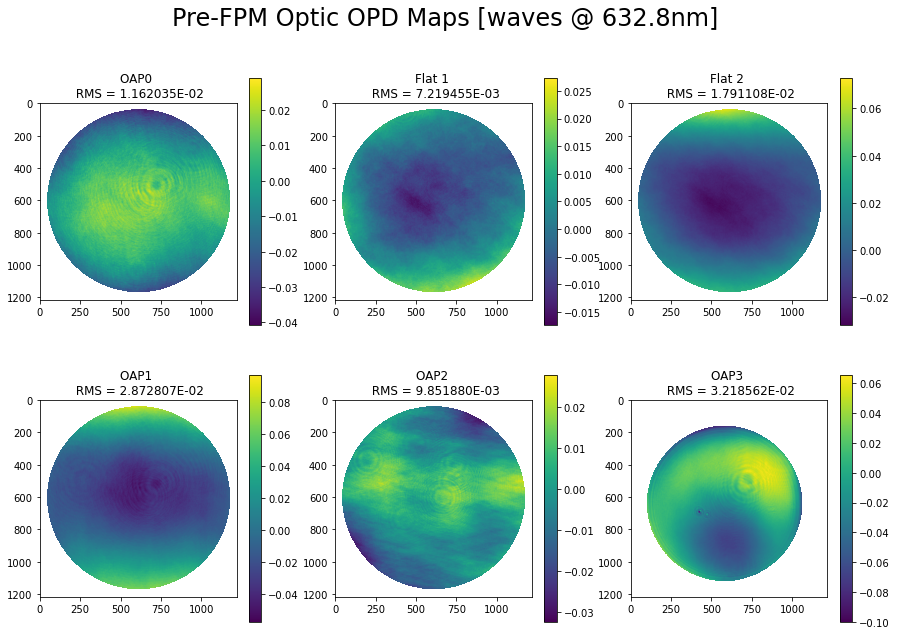

In [80]:
meas0 = f['measurement0']
dmask = f['measurement0'].get('Detectormask').value
# plt.figure()
# plt.imshow(dmask)
# plt.show()
genraw_data = f['measurement0']['genraw'].get('data').value
genraw_data[genraw_data >= 1000] = 0
# plt.imshow(genraw_data)
# plt.colorbar()

# It doesn't say but the data looks like waves. Write a function to get the piston/tip/tilt subtracted array.

def SubtractPistonTipTilt(h5pth):
    
    import h5py
    data = h5py.File(h5pth,'r')['measurement0']['genraw'].get('data').value
    
    # mask out the 1e38 vals at the edge of the detector
    data = np.ma.masked_greater(data,1000)
    data /= 2 # account for test in double-pass
    
    nterms = 3
    if h5pth == 'OAP1.h5':
        
        nterms = 8
        
    if h5pth == 'OAP3.h5':
        
        center = [-0.05,0.05]
        radius = 400
        
        x = np.linspace(-1,1,data.shape[0])
        x,y = np.meshgrid(x,x)
        data[np.sqrt((x-center[0])**2 + (y-center[1])**2) >= 0.8] = np.nan
        nterms = 11
        
    if h5pth == 'as-alligned_vvc_withDM_32avg.h5':
        
        center = [0.33,0.4]
        radius = 50
        x = np.linspace(-1,1,data.shape[0])
        x,y = np.meshgrid(x,x)
        data[np.sqrt((x-center[0])**2 + (y-center[1])**2) >= 0.59] = np.nan
        
        plt.figure()
        plt.title('masked data')
        plt.imshow(data)
        plt.show()
        nterms = 1
        
        return data,np.nanstd(data)
        
        # need to do some cropping of the data, where is the center I wonder?
    
    coeffs = poppy.zernike.decompose_opd(data,nterms=nterms)
#     print(coeffs)
    
    opd = poppy.zernike.compose_opd_from_basis(coeffs,npix=1218)
    print(opd.shape)
    
    data -= opd
    
    if h5pth == 'OAP3.h5':
        print(data.shape)
        print(type(data))
    
    return data,np.nanstd(data)
    
#     # Let's use masked arrays to make this easy
#     clone = data*0 + 1 
    
    
#     # dimension of masked array
#     dim = max(clone.count(axis=1))
    
    
#     x = np.linspace(-1,1,clone.shape[0])
#     x,y = np.meshgrid(x,x)
    
#     Z1 = clone
    
#     Z2 = Z1*x
# #     Z2 /= np.ma.max(Z2[609,:])
    
#     Z3 = Z1*y
# #     Z3 /= np.ma.max(Z3[:,609])
    
#     Z4 = Z1*(2*(x**2 + y**2)-1)
# #     Z4 /= np.ma.max(Z4[:,609])
    
#     Z5 = Z1*(x**2 - y**2)
    
#     Z6 = Z1*2*x*y
# #     Z6 /= np.ma.max(Z6[:,609])
    
    
#     # grab coefficient
#     z1coeff = np.ma.mean(Z1*data)
#     z2coeff = np.ma.mean(Z2*data)
#     z3coeff = np.ma.mean(Z3*data)
#     z4coeff = np.ma.mean(Z4*data)
#     z5coeff = np.ma.mean(Z5*data)
#     z6coeff = np.ma.mean(Z6*data)
    
#     print([z1coeff,z2coeff,z3coeff,z4coeff,z5coeff,z6coeff])
    
#     data = data - z1coeff*Z1 - z2coeff*Z2 - z3coeff*Z3 - z4coeff*Z4 - z5coeff*Z5
#     rms = np.std(data)
    
#     return data,rms
    
# def FindArrayCenter(array):
    
#     for i in range(len(array.shape[0])):
#         for j in range(len(array.shape[1])):
            
            
    
# #     plt.figure(figsize=[15,5])
# #     plt.subplot(131)
# #     plt.imshow(Z1*z1coeff)
# #     plt.colorbar()
# #     plt.subplot(132)
# #     plt.imshow(Z2*z2coeff)
# #     plt.colorbar()
# #     plt.subplot(133)
# #     plt.imshow(Z3*z3coeff)
# #     plt.colorbar()
# #     plt.show()
    
# #     print('Piston = ',z1coeff)
    
#     data = data - z1coeff*Z1 - z2coeff*Z2 - z3coeff*Z3
#     data *= 632.8
#     rms = np.ma.std(data)
    
#     return data,rms

oap0data,oap0rms = SubtractPistonTipTilt('M3.h5')
flat1data,flat1rms = SubtractPistonTipTilt('FLAT1.h5')
flat2data,flat2rms = SubtractPistonTipTilt('FLAT2.h5')
oap1data,oap1rms = SubtractPistonTipTilt('OAP1.h5')
oap2data,oap2rms = SubtractPistonTipTilt('OAP2.h5')
oap3data,oap3rms = SubtractPistonTipTilt('OAP3.h5')

print(oap3rms)

plt.figure(figsize=[15,10])
plt.suptitle('Pre-FPM Optic OPD Maps [waves @ 632.8nm]',fontsize=24)

# OAP0
plt.subplot(231)
plt.imshow(oap0data)
plt.colorbar()
plt.title('OAP0 \n RMS = {:2E}'.format(oap0rms))

plt.subplot(232)
plt.imshow(flat1data)
plt.colorbar()
plt.title('Flat 1 \n RMS = {:2E}'.format(flat1rms))

plt.subplot(233)
plt.imshow(flat2data)
plt.colorbar()
plt.title('Flat 2 \n RMS = {:2E}'.format(flat2rms))

plt.subplot(234)
plt.imshow(oap1data)
plt.colorbar()
plt.title('OAP1 \n RMS = {:2E}'.format(oap1rms))

plt.subplot(235)
plt.imshow(oap2data)
plt.colorbar()
plt.title('OAP2 \n RMS = {:2E}'.format(oap2rms))

# oap3data -= np.mean(oap3data)
# oap3data[oap3data >= 500] = np.nan
# oap3data[oap3data <= -250] = np.nan

plt.subplot(236)
plt.imshow(oap3data)
plt.colorbar()
plt.title('OAP3 \n RMS = {:2E}'.format(oap3rms))

plt.show()

<ipython-input-12-86275228f101>:9: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  data = meas0['genraw'].get('data').value


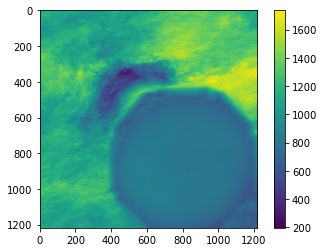

In [12]:
# fn = 'M3.h5'
fn = 'as-alligned_vvc_withDM_32avg.h5'
f = h5py.File(fn, 'r')
f['measurement0'].keys()
meas0 = f['measurement0']
intfgm = meas0['reserve_interferogram']['frame4']['data']
plt.imshow(intfgm)
plt.colorbar()
data = meas0['genraw'].get('data').value
plt.imshow(data)

<ipython-input-68-34baffbecc34>:16: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  data = h5py.File(h5pth,'r')['measurement0']['genraw'].get('data').value


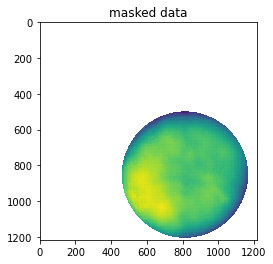

In [70]:
as_aligned_data,as_aligned_rms = SubtractPistonTipTilt('as-alligned_vvc_withDM_32avg.h5')


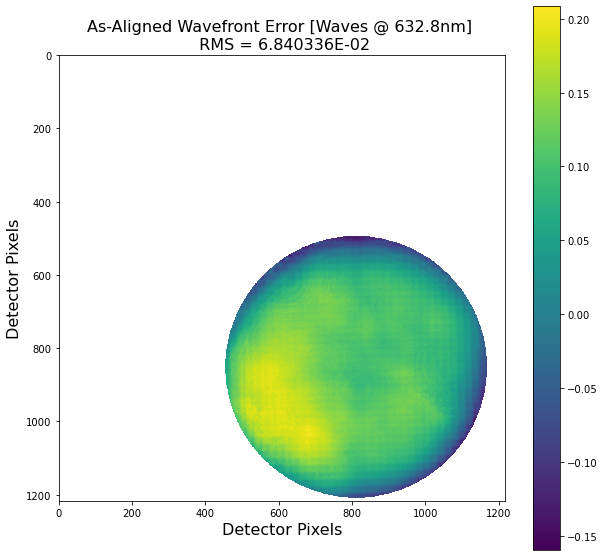

In [77]:
plt.figure(figsize=[10,10])
plt.title('As-Aligned Wavefront Error [Waves @ 632.8nm] \n RMS = {:2E}'.format(as_aligned_rms),fontsize=16)
plt.imshow(as_aligned_data)
plt.xlabel('Detector Pixels',fontsize=16)
plt.ylabel('Detector Pixels',fontsize=16)
plt.colorbar()
plt.show()